In [17]:
import os
from bson.json_util import dumps
from path import *
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from PIL import Image


### Utils

In [18]:
def convert_list_to_dict(list):
	my_dict = {}
	for el in list:
		if el[0] not in STOPWORDS:
			my_dict[el[0]] = int(el[1])
	return my_dict 

COLORMAP = {
	"anger": "mediumvioletred",
	"anticipation": "orange",
	"disgust": "violet",
	"fear": "forestgreen",
	"joy": "yellow",
	"sadness": "darkviolet",
	"surprise": "mediumaquamarine",
	"trust": "yellowgreen"
}

### MongoDB
Goal 1: per creare le word clouds per ciascun sentimento, per ciascun sentiment file,
usare la aggregation pipeline e calcolare la frequenza totale nei messaggi Twitter di ciascun token: word, hashtag, emoji, emoticon

Goal 2: calcolare le statistiche (percentuali) delle parole delle risorse lessicali presenti anche nei messaggi di Twitter

In [19]:
from pymongo import MongoClient
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from constants import urlLocal
import multidict as multidict

#### Connection

In [20]:
client = MongoClient(urlLocal)
db = client.maadb_project

#### WordCloud Pipeline

In [21]:
def get_words_and_frequency_mongodb(sentiment, max_words=None):
    pipeline = [
        {'$match': {'sentiment': sentiment}}, # fai match col sentimento corrente
        {'$unwind': '$words'}, # spacchettare gli array
        {'$group': {'_id': {'lemma': '$words.lemma', 'pos_tag': '$words.pos_tag'}, 'occurences': {'$sum': '$words.freq'}}}, # raggruppi words lemma e postag come id e come occurrences la somma delel frequenze
        {'$sort': {'occurences': -1}}, # ordine decrescente
    ]
    if max_words is not None:
        pipeline.append({'$limit': max_words})

    tweet_words_per_sent = db.tweets.aggregate(pipeline)
    output_doc_frequences = [x for x in tweet_words_per_sent]
    

    result = multidict.MultiDict()
    for word in output_doc_frequences:
        key = word['_id']['lemma']
        value = word['occurences']
        if key not in STOPWORDS:
            result.add(key, value)
    return result
    
get_words_and_frequency_mongodb("anger", 20)

<MultiDict('go': 3367, 'hate': 2861, 'one': 2629, 'know': 2595, 'people': 2573, 'back': 2192, 'want': 2138, 'fuck': 2113, 'got': 2077, 'really': 1997, 'time': 1975, 'shit': 1932, 'going': 1879, 'dx': 1816, 'work': 1791, 'right': 1748, 'day': 1696, 'even': 1680)>

#### Generatore WordCloud

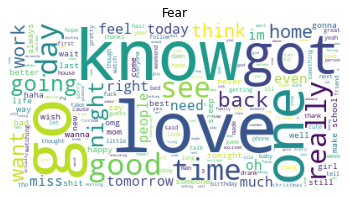

In [44]:
def generate_wordcloud_mongodb(sentiment):
    frequencies = get_words_and_frequency_mongodb(sentiment)
    wordcloud = WordCloud(background_color="white", ).generate_from_frequencies(frequencies)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title(sentiment.capitalize())
    plt.show()

    
generate_wordcloud_mongodb("fear")

#### EmojiCloud

In [23]:
def get_tokens_and_frequency_mongodb(token_type, sentiment, max_documents=None):
	if token_type.lower() not in ["emojis", "emoticons", "hashtags"]:
		print("Errore: tipo non valido.")
		return
	token_type = '$' + token_type.lower()
	
	pipeline = [
		{'$match': {'sentiment': sentiment}},
		{'$unwind': token_type},
		{'$group': {'_id': token_type, 'occurences': {'$sum': 1}}},
		{'$sort': {'occurences': -1}},
	]
	if max_documents is not None:
		pipeline.append({'$limit': max_documents})
	token_per_sent = db.tweets.aggregate(pipeline)
	output_doc_frequences = [x for x in token_per_sent]
	
	result = multidict.MultiDict()
	for word in output_doc_frequences:
		key = word['_id']
		value = word['occurences']
		result.add(key, value)
	return result

get_tokens_and_frequency_mongodb('emoticons', "joy", 10)

<MultiDict(':)': 20294, '(:': 6480, ':-)': 3154, ':3': 2797, ':d': 2712, ':p': 2214, 'xd': 1686, '<3': 1551, '^.^': 588, '=)': 458)>

#### Generatore EmojiCloud

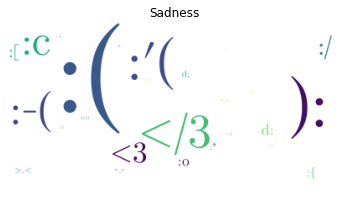

In [55]:
def generate_emojicloud_mongodb(sentiment, type):
    frequencies = get_tokens_and_frequency_mongodb(type, sentiment)
    wordcloud = WordCloud(font_path='./Symbola.otf', background_color="white").generate_from_frequencies(frequencies)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title(sentiment.capitalize())
    plt.show()

generate_emojicloud_mongodb("sadness", 'emoticons')

#### Recupero numero di parole condivise 

In [33]:
#Questa pipeline abbastanza incomprensibile, domani vediamola meglio
def compute_shared_words_mongodb():
    tweet_sentiments = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust',]
    pipeline = [
        {'$project': {
            '_id': False,
            'sentiment': True,
            'words': {
                '$filter': {
                    'input': '$words',
                    'cond': {'$ne': ['$$this.in_lex_resources', None]}
                }
            }
        }},
        {'$unwind': '$words'},
        {'$project': {
            'lemma': '$words.lemma', 
            'sentiment': True,
            'words.in_lex_resources': {
                '$filter': {
                    'input': '$words.in_lex_resources',
                    'cond': {'$in': ['$$this.sentiment', tweet_sentiments]}
                }
            }
        }},
        {'$unwind': '$words.in_lex_resources'},
        {'$project': { 
            'lemma': True,
            'resource': '$words.in_lex_resources.resource', 
            'sentiment': True,
            'sent_equal': {'$eq': ['$sentiment', '$words.in_lex_resources.sentiment']}
        }},
        {'$match': {'sent_equal': True}},
        {'$group': {'_id': {'resource': '$resource', 'sentiment': '$sentiment'}, 'words': {'$addToSet': '$lemma'}}},
        {'$project': {'_id': True, 'count': {'$size': '$words'}}},
        {'$sort' : {'sentiment' : -1}}
    ]
    n_shared_words =  db.tweets.aggregate(pipeline, allowDiskUse=True)
    n_shared_words = dict(((x['_id']['resource'], x['_id']['sentiment']), x['count']) for x in n_shared_words)
    return n_shared_words

n_shared_words_mongodb = compute_shared_words_mongodb()
n_shared_words_mongodb

{('sentisense', 'anticipation'): 99,
 ('sentisense', 'disgust'): 275,
 ('NRC', 'joy'): 417,
 ('NRC', 'fear'): 614,
 ('sentisense', 'surprise'): 16,
 ('NRC', 'disgust'): 487,
 ('NRC', 'sadness'): 524,
 ('sentisense', 'joy'): 61,
 ('NRC', 'trust'): 616,
 ('NRC', 'anger'): 602,
 ('NRC', 'surprise'): 296,
 ('EmoSN', 'anger'): 202,
 ('sentisense', 'fear'): 93,
 ('NRC', 'anticipation'): 430,
 ('EmoSN', 'joy'): 2305,
 ('sentisense', 'anger'): 30,
 ('sentisense', 'sadness'): 52}

#### Recupero numero parole risorse lessicali da database

In [26]:
def get_number_words_of_lex_res():
    lex_res = db.lexResources.find({})
    return dict(((x['id'], x['sentiment']), x['totNumberWords']) for x in lex_res)

tot_number_words_dict = get_number_words_of_lex_res()

#### Recupero numero parole nei tweet da database

In [27]:
def get_number_words_of_tweets():
    pipeline = [
        {'$unwind': '$words'},
        {'$group': {'_id': {'lemma': '$words.lemma', 'sentiment': '$sentiment'}, 'idc': {'$first': '$words.lemma'}}},
        {'$group': {'_id': '$_id.sentiment', 'number_of_words': {'$sum': 1}}},
    ]
    result = db.tweets.aggregate(pipeline)
    return dict((x['_id'], x['number_of_words']) for x in result)

tweet_words_of_sent_dict = get_number_words_of_tweets()
print(tweet_words_of_sent_dict)

{'anger': 28710, 'trust': 29688, 'sadness': 26585, 'surprise': 30406, 'anticipation': 26256, 'disgust': 28707, 'joy': 32310, 'fear': 25500}


#### Calcolo risultati

In [28]:
PERC_TWEET = {}
PERC_LEX_RES = {}
for key in n_shared_words_mongodb.keys():
    res, sent = key
    PERC_TWEET[key] = round(n_shared_words_mongodb[key] / tweet_words_of_sent_dict[sent], 6)
    PERC_LEX_RES[key] = round(n_shared_words_mongodb[key] / tot_number_words_dict[key], 6)
    #print(f"Resource {res}, sentiment {sent}:\n percentuale tweet: {perc_tweet[key]},\n percentuale risorse: {perc_lex_res[key]}")

#### Supporto per istogrammi

In [29]:
def build_plot_label(couples):
    labels = []
    for res, sent in couples:
        res = 'SS' if res == "sentisense" else res
        res = 'ESN' if res == "EmoSN" else res
        label = res + '_' + sent[:3]
        labels.append(label)
    return labels

def build_colors(couples):
    colors = []
    for res, sent in couples:
        colors.append(COLORMAP[sent])
    return colors

#### Istogramma Tweet-Risorse Lessicali
Il grafico in questione indica la percentuale di parole all'interno dei tweet, le quali sono presenti all'interno delle risorse lessicali. Il tutto viene diviso per ogni documento analizzato.

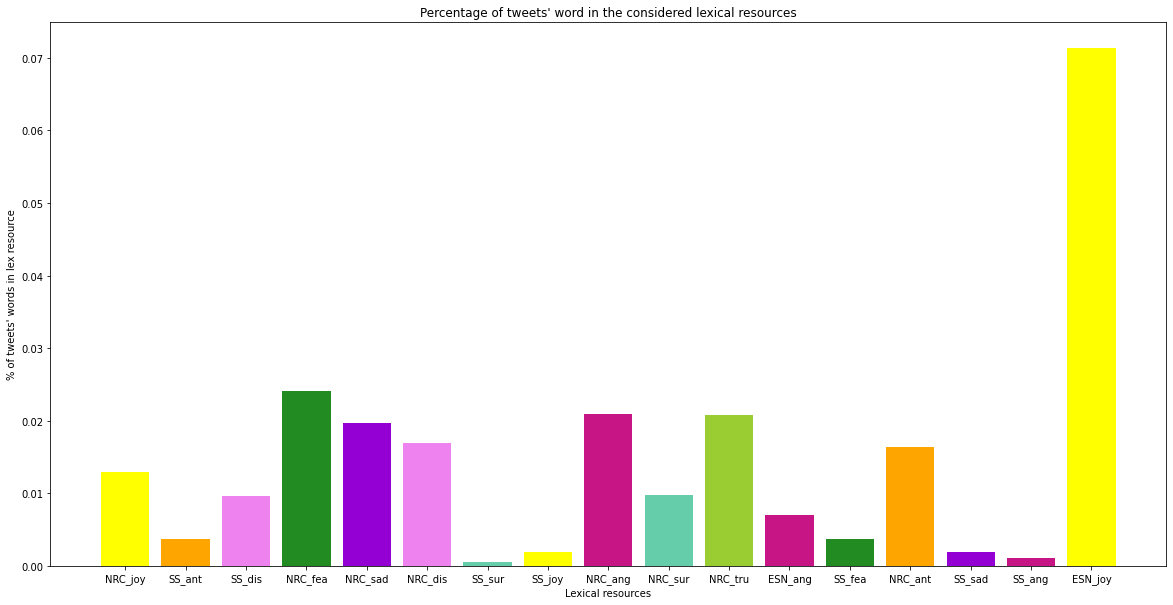

In [30]:
#Ovviamente finche non fixiamo la pipeline precedente non funziona questo, ne l'altro
def visualize_tweet_bar_plot(perc_tweet):
    tweet_sent = build_plot_label(perc_tweet.keys())
    colors = build_colors(perc_tweet.keys())
    values = list(perc_tweet.values())
    fig = plt.figure(figsize = (20, 10))
    plt.bar(tweet_sent, values, color=colors)
    plt.xlabel("Lexical resources")
    plt.ylabel("% of tweets' words in lex resource")
    plt.title("Percentage of tweets' word in the considered lexical resources")
    plt.show()

visualize_tweet_bar_plot(PERC_TWEET)

#### Istogramma Risorse Lessicali-Tweet

Il grafico in questione indica la percentuale di parole all'interno delle risorse lessicali, le quali sono state utilizzate all'interno dei tweet. Il tutto viene diviso per ogni documento analizzato.

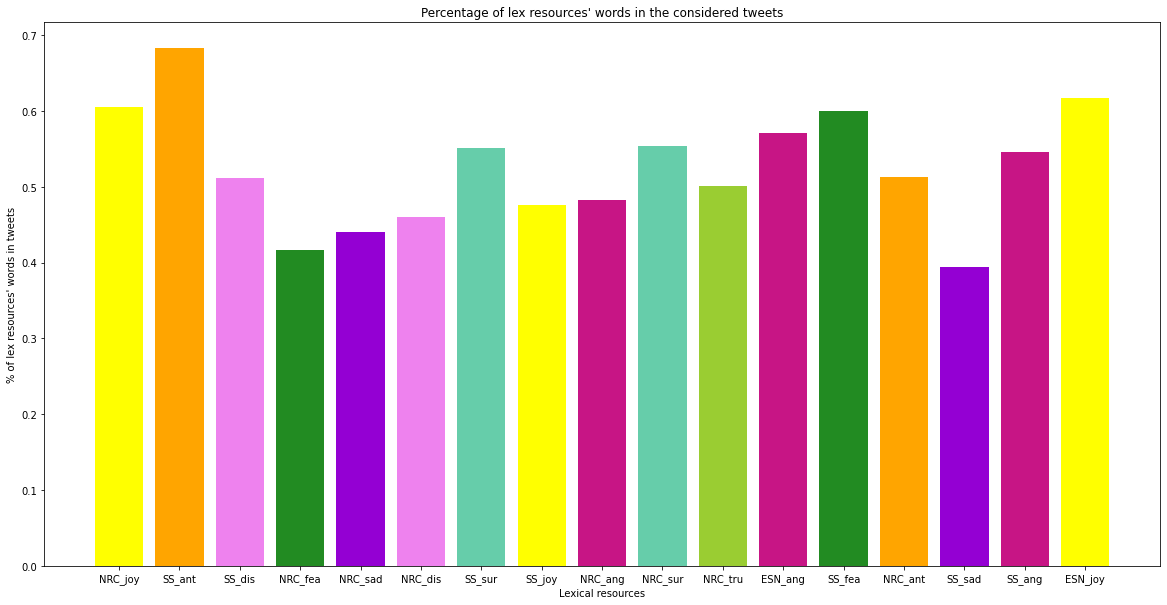

In [31]:
def visualize_lex_res_bar_plot(perc_lex_res):
    tweet_sent = build_plot_label(perc_lex_res.keys())
    colors = build_colors(perc_lex_res.keys())
    values = list(perc_lex_res.values())
    fig = plt.figure(figsize = (20, 10))
    plt.bar(tweet_sent, values, color=colors)
    plt.xlabel("Lexical resources")
    plt.ylabel("% of lex resources' words in tweets")
    plt.title("Percentage of lex resources' words in the considered tweets")
    plt.show()

visualize_lex_res_bar_plot(PERC_LEX_RES)

### Inserimento nuove risorse lessicali

In [32]:
def build_new_resources():
    pipeline = [
        {'$project': {
            '_id': False,
            'sentiment': True,
            'words': {
                '$filter': {
                    'input': '$words',
                    'cond': {'$eq': ['$$this.in_lex_resources', []]}
                }
            }
        }},
        {'$unwind': '$words'},
        {'$group': {'_id': {'lemma': '$words.lemma', 'sentiment': '$sentiment'}, 'count': {'$sum': '$words.freq'}}},
        {'$match': {'count': {'$gt': 100}}},
        {'$project': {'lemma': '$_id.lemma', 'sentiment': '$_id.sentiment', 'count': '$count'}},
        {'$sort': {'lemma': 1, 'count': -1, 'sentiment': 1}},
        {'$group': {'_id': '$lemma', 'sentiment': {'$first': '$sentiment'}}},
        {'$group': {'_id': '$sentiment', 'new_words': {'$addToSet': '$_id'}}},
        {'$project': {'sentiment': '$_id', 'new_words': True}},
        {'$project': {'_id': False}},
        {'$out': 'newResource'},
    ]
    new_res =  db.tweets.aggregate(pipeline, allowDiskUse=True)
    new_res = db.newResource.find()
    return [x for x in new_res]

new_res = build_new_resources()

db.newResource.find_one({'sentiment': 'fear'}, {'_id': False, 'new_words': True})

{'new_words': ['mama', 'anyone', 'retweet', 'met', 'starbucks']}

# Relazionale
1. list the lexical resources containing each word, so that
we can rely upon a unique resource source obtained by
the fusion of the single resources.
2. count the number of occurrences of each word in the
Twitter messages for each emotion so that at the end we
can draw a word cloud associated to the most frequent
words in each emotion.

In [70]:
import mysql.connector

### Connection

In [71]:
PW = 'MongoMongoMongo97'

def create_db_connection(host_name, user_name, user_password, db_name):
	connection = mysql.connector.connect(
		host=host_name,
		user=user_name,
		passwd=user_password,
		database=db_name
	)
	return connection

CONNECTION = create_db_connection("localhost", "root", PW, 'maadb_project')

### Query

In [72]:
def get_data_from_db(query):
    cursor = CONNECTION.cursor()
    cursor.execute(query)
    return cursor
  
def get_words_and_frequency_relational(sentiment, num_words):
    return get_data_from_db(f"""SELECT lemma, sum(frequence) AS occurrences
                                        FROM (
                                            SELECT *
                                            FROM wordsintweet
                                            WHERE wordsintweet.id_tweet IN (
                                                SELECT id_tweet
                                                FROM tweet
                                                WHERE sentiment = '{sentiment}'
                                            )
                                        ) AS boh JOIN word ON word.id_word = boh.id_word
                                        GROUP BY lemma
                                        ORDER BY occurrences DESC
                                        limit {num_words}""")

def get_tokens_and_frequency_relational(sentiment, num_tokens, type):
    if type not in ["emojis", "emoticons"]:
        return "Errore!"
    return get_data_from_db(f"""SELECT token, sum(frequence) AS occurrences
                                        FROM (
                                            SELECT *
                                            FROM tokensintweet
                                            WHERE tokensintweet.id_tweet IN (
                                                SELECT id_tweet
                                                FROM tweet
                                                WHERE sentiment = '{sentiment}'
                                            )
                                        ) AS boh JOIN token ON token.id_token = boh.id_token
                                        WHERE type = '{type}'
                                        GROUP BY token
                                        ORDER BY occurrences DESC
                                        limit {num_tokens}""")

#### Generatore di WordCloud

In [73]:
def generate_wordcloud_relational(sentiment, num_words):
	data = get_words_and_frequency_relational(sentiment, num_words).fetchall()
	counter = convert_list_to_dict(data)
	wc = WordCloud().generate_from_frequencies(counter)
	plt.imshow(wc)
	plt.axis("off")
	plt.title(sentiment.capitalize())
	plt.show()

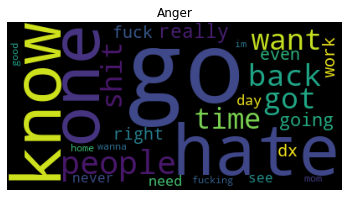

In [74]:
generate_wordcloud_relational("anger", 30)

#### Generatore di EmojiCloud

In [75]:
def generate_emojicloud_relational(sentiment, num_tokens, token_type):
	data = get_tokens_and_frequency_relational(sentiment, num_tokens, token_type).fetchall()
	counter = convert_list_to_dict(data)
	wc = WordCloud(font_path='./Symbola.otf').generate_from_frequencies(counter)
	plt.imshow(wc)
	plt.axis("off")
	plt.title(sentiment.capitalize())
	plt.show()

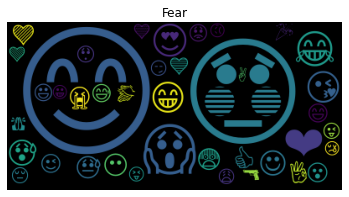

In [76]:
generate_emojicloud_relational("fear", 40, "emojis")

#### Recupero numero di parole condivise

In [77]:
def compute_shared_words_relational():
    query = """ 
        SELECT sentiment, resource_name, count(*) AS N_shared_words
        FROM (
            SELECT DISTINCT *
            FROM (
                SELECT * 
                FROM wordsinlexres JOIN lexical_resource ON id_lexres = lexical_resource.id_lex_res
            ) AS lex_res
            WHERE (id_word, sentiment) IN (
	            SELECT id_word, sentiment
                FROM wordsintweet JOIN tweet ON tweet.id_tweet = wordsintweet.id_tweet
            )
        ) AS t1
        GROUP BY id_lexres
    """
    data = get_data_from_db(query).fetchall()
    return dict(((res, sent), n) for sent, res, n in data)

shared_words_relational = compute_shared_words_relational()

#### Recupero numero parole risorse lessicali da database


In [78]:
def get_number_words_of_lex_res_relational():
    query = """
        SELECT resource_name, sentiment, number_of_words
        FROM lexical_resource
    """
    data = get_data_from_db(query).fetchall()
    return dict(((res, sent), n) for res, sent, n in data)

tot_number_words_dict = get_number_words_of_lex_res_relational()
print(tot_number_words_dict)

{('EmoSN', 'anger'): 354, ('NRC', 'anger'): 1247, ('sentisense', 'anger'): 55, ('NRC', 'anticipation'): 839, ('sentisense', 'anticipation'): 145, ('NRC', 'disgust'): 1058, ('sentisense', 'disgust'): 537, ('sentisense', 'hate'): 16, ('NRC', 'fear'): 1476, ('sentisense', 'fear'): 155, ('sentisense', 'hope'): 51, ('EmoSN', 'joy'): 3734, ('NRC', 'joy'): 689, ('sentisense', 'joy'): 128, ('sentisense', 'like'): 338, ('sentisense', 'love'): 52, ('GI', 'neg'): 1669, ('HL', 'neg'): 4782, ('ET', 'neg'): 1999, ('LIWC', 'neg'): 500, ('GI', 'pos'): 1632, ('HL', 'pos'): 2006, ('ET', 'pos'): 2782, ('LIWC', 'pos'): 405, ('NRC', 'sadness'): 1191, ('sentisense', 'sadness'): 132, ('NRC', 'surprise'): 534, ('sentisense', 'surprise'): 29, ('NRC', 'trust'): 1231}


#### Recupero numero parole risorse lessicali da database


In [79]:
def get_number_words_of_tweets_relational():
    query = """ 
        SELECT sentiment, count(id_word)
        FROM (
            SELECT DISTINCT sentiment, id_word
            FROM tweet JOIN wordsintweet ON tweet.id_tweet = wordsintweet.id_tweet
        ) AS t
        GROUP BY sentiment
    """
    data = get_data_from_db(query).fetchall()
    return dict(data)

tweet_words_of_sent_dict = get_number_words_of_tweets_relational()

#### Calcolo risultati
Vengono calcolati gli overlap tra le risorse lessicali e i tweet

In [80]:
PERC_TWEET = {}
PERC_LEX_RES = {}
for key in shared_words_relational.keys():
    res, sent = key
    PERC_TWEET[key] = round(shared_words_relational[key] / tweet_words_of_sent_dict[sent], 6)
    PERC_LEX_RES[key] = round(shared_words_relational[key] / tot_number_words_dict[key], 6)

#### Istogramma Tweet-Risorse Lessicali
Il grafico in questione indica la percentuale di parole all'interno dei tweet, le quali sono presenti all'interno delle risorse lessicali. Il tutto viene diviso per ogni documento analizzato.

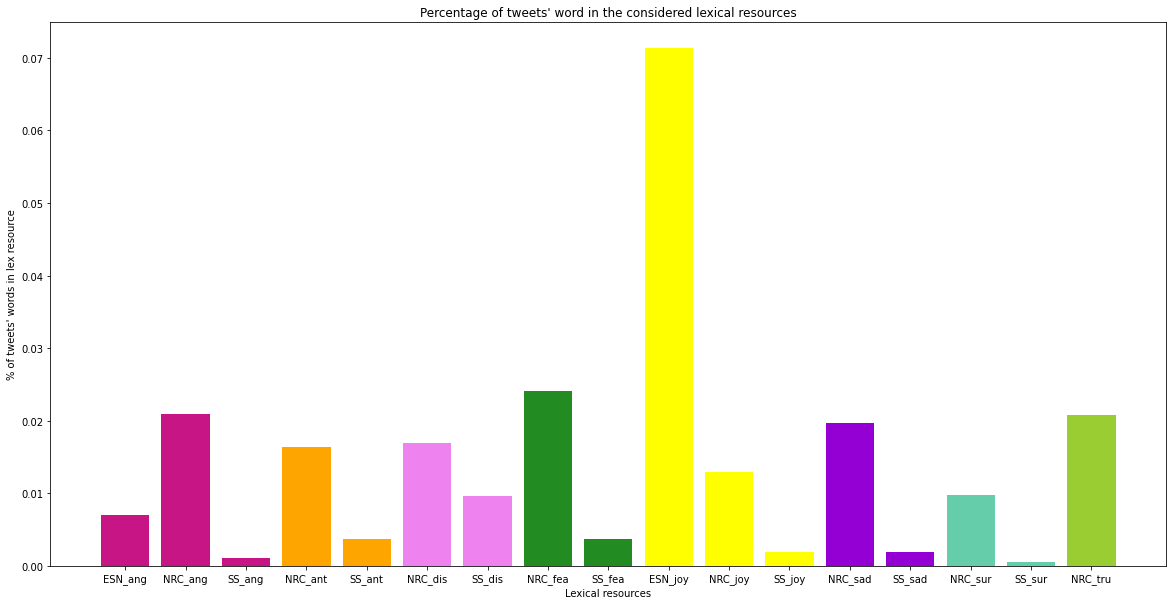

In [81]:
def visualize_tweet_bar_plot(perc_tweet):
    tweet_sent = build_plot_label(perc_tweet.keys())
    colors = build_colors(perc_tweet.keys())
    values = list(perc_tweet.values())
    fig = plt.figure(figsize = (20, 10))
    plt.bar(tweet_sent, values, color=colors)
    plt.xlabel("Lexical resources")
    plt.ylabel("% of tweets' words in lex resource")
    plt.title("Percentage of tweets' word in the considered lexical resources")
    plt.show()

visualize_tweet_bar_plot(PERC_TWEET)

#### Istogramma Risorse Lessicali-Tweet

Il grafico in questione indica la percentuale di parole all'interno delle risorse lessicali, le quali sono state utilizzate all'interno dei tweet. Il tutto viene diviso per ogni documento analizzato.

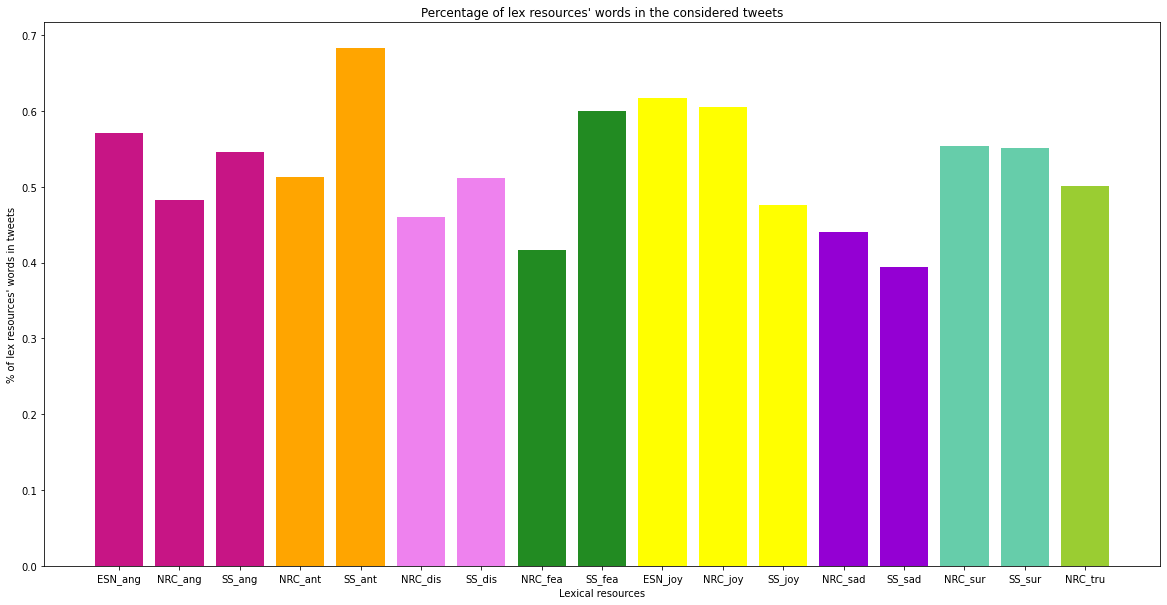

In [82]:
def visualize_lex_res_bar_plot(perc_lex_res):
    tweet_sent = build_plot_label(perc_lex_res.keys())
    colors = build_colors(perc_lex_res.keys())
    values = list(perc_lex_res.values())
    fig = plt.figure(figsize = (20, 10))
    plt.bar(tweet_sent, values, color=colors)
    plt.xlabel("Lexical resources")
    plt.ylabel("% of lex resources' words in tweets")
    plt.title("Percentage of lex resources' words in the considered tweets")
    plt.show()

visualize_lex_res_bar_plot(PERC_LEX_RES)